In [63]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, roc_curve

In [13]:
train_data = pd.read_csv('./data_preprocess_v2/train_df_day_5_1.csv')
test_data = pd.read_csv('./data_preprocess_v2/test_df_day_5_1.csv')

In [76]:
dtr = RandomForestRegressor()
RandomForestRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

RandomForestRegressor(ccp_alpha=0, max_depth=6)

In [90]:
independe_var = ['Volume (t-5)', 'Volume (t-4)', 'Volume (t-3)', 'Volume (t-2)', 'Volume (t-1)',\
                     'Close (t-5)', 'Close (t-4)', 'Close (t-3)', 'Close (t-2)', 'Close (t-1)']
train_data[independe_var] = (train_data[independe_var]-train_data[independe_var].min())/(train_data[independe_var].max()-train_data[independe_var].min())
test_data[independe_var] = (test_data[independe_var]-test_data[independe_var].min())/(test_data[independe_var].max()-test_data[independe_var].min())

In [93]:
train = train_data.drop(["Close (t)","movement"],1)
label_train = train_data["Close (t)"]
test = test_data.drop(["Close (t)","movement"],1)
label_test = test_data["Close (t)"]

In [94]:
dtr.fit(train, label_train)

score = dtr.score(train, label_train)
print("R-squared:", score) 

ypred = dtr.predict(test)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.9991609240809277
MSE:  1.2226072513270745
RMSE:  0.6113036256635372


In [79]:
ypred_train = dtr.predict(train)

In [80]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
label_train_move = ypred_train - train["Close (t-1)"]
label_train_move = label_train_move.where(label_train_move>=0, 0).where(label_train_move<=0, 1)
label_test_move = test_data["movement"]

In [81]:
def xgboost(train, label_train, test, label_test, evaluate = 't', search = 'g'):
    import xgboost as xgb
    xgb_params = {'max_depth': [2,3], 
              'learning_rate': [x/10 for x in list(range(1,7))],
              'n_estimators': [0, 25, 50],
              'objective': ['binary:logistic']}
    xgb_model = xgb.XGBClassifier(gamma=1, random_state=42, reg_lambda=200, use_label_encoder=False, eval_metric = 'logloss')
    if search == 'g':
        xgb_model = GridSearchCV(xgb_model, xgb_params, scoring='roc_auc')
        xgb_model.fit(train, label_train)
        print(xgb_model.best_estimator_)
    else:
        xgb_model = RandomizedSearchCV(xgb_model, xgb_params)
        xgb_model.fit(train, label_train)
        print(xgb_model.best_params_)
        print(xgb_model.best_score_)
        
    if evaluate == 't':
        evaluate_model(xgb_model, train, label_train)
    else:
        evaluate_model(xgb_model, test, label_test)
    

In [ ]:
def randomforest(train, label_train, test, label_test, evaluate = 't', search = 'g'):
    rfc_params = {'n_estimators': [25,50,100],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3,4,5,6],
                'criterion' :['gini', 'entropy'],
                'random_state': [42]}

    rfc_model = RandomForestClassifier()

    if search == 'g':
        rfc_model = GridSearchCV(rfc_model, rfc_params, scoring='roc_auc')
        rfc_model = rfc_model.fit(train, label_train)
        print(rfc_model.best_estimator_)
    else:
        rfc_model = RandomizedSearchCV(rfc_model, rfc_params)
        rfc_model = rfc_model.fit(train, label_train)
        print(rfc_model.best_params_)
        print(rfc_model.best_score_)

    if evaluate == 't':
        evaluate_model(rfc_model, train, label_train)
    else:
        evaluate_model(rfc_model, test, label_test)

In [83]:
def decisiontree (train, label_train, test, label_test, evaluate = 't', search = 'g'):
    dt_params = {"criterion":['gini','entropy'],
                 'max_depth':[3,4,5,6,7,8],
                 'random_state': [42]}

    dt_model = DecisionTreeClassifier()
    if search == 'g':
        dt_model = GridSearchCV(dt_model, dt_params, scoring='roc_auc')
        dt_model.fit(train, label_train)
        print(dt_model.best_estimator_)
    else:
        dt_model = RandomizedSearchCV(dt_model, dt_params)
        dt_model = dt_model.fit(train, label_train)
        print(dt_model.best_params_)
        print(dt_model.best_score_)
    
    if evaluate == 't':
        evaluate_model(dt_model, train, label_train)
    else:
        evaluate_model(dt_model, test, label_test)

In [84]:
def evaluate_model(model, test, label_test):
    predicted = model.predict(test)
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    plot_confusion_matrix(model, test, label_test,
                      display_labels=list(set(label_test)),
                      cmap=plt.cm.Blues)
    
    classification = classification_report(label_test, predicted)
    print(classification)

{'objective': 'binary:logistic', 'n_estimators': 25, 'max_depth': 3, 'learning_rate': 0.5}
0.5094890255019753
accuracy: 0.6381138392857143
precision: 0.6384679765751561
recall: 0.6381138392857143
f1 0.6371825834896713
metrics.roc_auc_score 0.6371322081715456
              precision    recall  f1-score   support

         0.0       0.64      0.59      0.61      1756
         1.0       0.63      0.69      0.66      1828

    accuracy                           0.64      3584
   macro avg       0.64      0.64      0.64      3584
weighted avg       0.64      0.64      0.64      3584

{'objective': 'binary:logistic', 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2}
0.509762121814201
accuracy: 0.4947916666666667
precision: 0.4931406847371633
recall: 0.4947916666666667
f1 0.48562857263429815
metrics.roc_auc_score 0.4935746683057098
              precision    recall  f1-score   support

           0       0.50      0.63      0.56       775
           1       0.49      0.36      0.41   

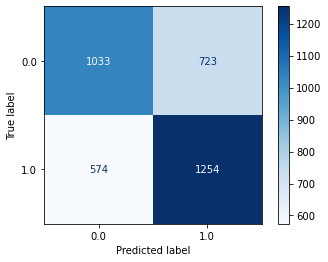

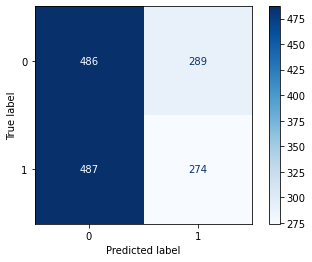

In [87]:
#xgb_g_train = xgboost(train, label_train_move, test, label_test_move)
#xgb_g_test = xgboost(train, label_train_move, test, label_test_move,  evaluate = 's')
xgb_r_train = xgboost(train, label_train_move, test, label_test_move, search = 'r')
xgb_r_test = xgboost(train, label_train_move, test, label_test_move, evaluate = 's', search = 'r')

In [86]:
rfc_g_train = randomforest(train,label_train_move, test, label_test_move)
rfc_g_test = randomforest(train, label_train_move, test, label_test_move,  evaluate = 's')
#rfc_r_train = randomforest(train, label_train, test, label_test,  search = 'r')
#rfc_r_test = randomforest(train, label_train, test, label_test,  evaluate = 's', search = 'r')

KeyboardInterrupt: 

{'random_state': 42, 'max_depth': 4, 'criterion': 'entropy'}
0.5072551677925559
accuracy: 0.5184151785714286
precision: 0.6222231381899351
recall: 0.5184151785714286
f1 0.3707395108164087
metrics.roc_auc_score 0.5087327973362974
              precision    recall  f1-score   support

         0.0       0.73      0.03      0.05      1756
         1.0       0.51      0.99      0.68      1828

    accuracy                           0.52      3584
   macro avg       0.62      0.51      0.36      3584
weighted avg       0.62      0.52      0.37      3584

{'random_state': 42, 'max_depth': 4, 'criterion': 'entropy'}
0.5072551677925559
accuracy: 0.4739583333333333
precision: 0.4678716078718124
recall: 0.4739583333333333
f1 0.43761031539351847
metrics.roc_auc_score 0.4762765461404773
              precision    recall  f1-score   support

           0       0.46      0.22      0.30       775
           1       0.48      0.73      0.58       761

    accuracy                           0.47      1

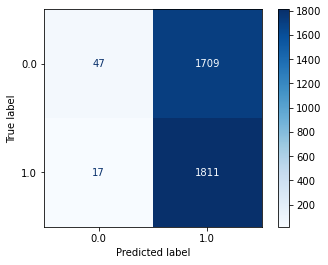

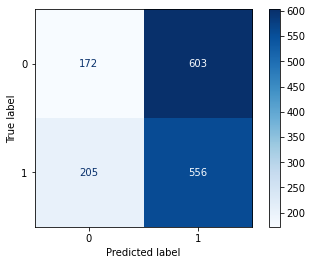

In [89]:
#dt_g_train = decisiontree(train, label_train_move, test, label_test_move)
#dt_g_test = decisiontree(train, label_train_move, test, label_test_move, evaluate = 's')
dt_r_train = decisiontree(train, label_train_move, test, label_test_move, search = 'r')
dt_r_test = decisiontree(train, label_train_move, test, label_test_move, evaluate = 's', search = 'r')